In [76]:
# interpret model scores

# Modeling Our Data

---

## Imports and Functions

---

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to remove
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [14]:
def qual_to_num(data, feature):
    qual_conversion = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, np.nan: 0}
    
    data[feature] = data[feature].apply(lambda x: qual_conversion[x])
    
    return data


def vif_df(df):
    corr_features = df.columns
    vif_values = [variance_inflation_factor(df.values, i) for i in range(len(corr_features))]
    
    vif = pd.DataFrame(vif_values,
                   index = corr_features,
                   columns = ['vif']).sort_values(by = 'vif', ascending = False)
    
    return vif


def setup_test():
    test_data = pd.read_csv('../datasets/test.csv')
    test_features = ['MS Zoning', 'Lot Area', 'Land Contour', 'Land Slope', 'Neighborhood', 'Condition 1',
            'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
           'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
           'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Kitchen Qual', 'Bedroom AbvGr',
           'Full Bath', 'Half Bath', 'Fireplaces', 'Fireplace Qu', 'BsmtFin SF 1', 'Bsmt Unf SF', '1st Flr SF', '2nd Flr SF', 'Sale Type',]
    
    
    test_data = test_data[test_features]
    test_data.columns = [col.lower().replace(' ','_').replace('/','_') for col in test_data.columns]
    
    
    # converts descriptive rating to numerical
    test_data = qual_to_num(test_data, 'bsmt_qual')
    test_data = qual_to_num(test_data, 'bsmt_cond')
    test_data = qual_to_num(test_data, 'kitchen_qual')
    test_data = qual_to_num(test_data, 'exter_qual')
    test_data = qual_to_num(test_data, 'exter_cond')
    test_data = qual_to_num(test_data, 'fireplace_qu')
    
    # combines basment quality and condition ratings via multiplication
    test_data['bsmt_qual_cond'] = test_data['bsmt_qual'] * test_data['bsmt_cond']
    test_data.drop(columns = ['bsmt_qual', 'bsmt_cond'], inplace = True)
    
    # combines overall quality and condition into one column via multiplication
    test_data['qual_cond'] = test_data['overall_qual'] * test_data['overall_cond']
    test_data.drop(columns = ['overall_qual', 'overall_cond'], inplace = True)

    # combines exterior quality and condition into one column via multiplication
    test_data['exter_qual_cond'] = test_data['exter_qual'] * test_data['exter_cond']
    test_data.drop(columns = ['exter_qual', 'exter_cond'], inplace = True)

    # combines fireplace count and quality rating via multiplication
    test_data['fireplaces_weighted'] = test_data['fireplaces'] * test_data['fireplace_qu']
    test_data.drop(columns = ['fireplaces', 'fireplace_qu'], inplace = True)
    
    # adds square feet (SF) measurements with weights:
    # 1*(Finished SF) + 0.5(Unfinished SF)
    test_data['bsmt_weighted_sf'] = test_data['bsmtfin_sf_1'] + 0.5*test_data['bsmt_unf_sf']
    test_data.drop(columns = ['bsmtfin_sf_1', 'bsmt_unf_sf'], inplace = True)
    
    # combines full bath and half bath into one column
    test_data['bath'] = test_data['full_bath'] + 0.5*test_data['half_bath']
    test_data.drop(columns = ['full_bath', 'half_bath'], inplace = True)
    
    #combines 1st floor and 2nd floor square feet areas
    test_data['sq_ft'] = test_data['1st_flr_sf'] + test_data['2nd_flr_sf']
    test_data.drop(columns = ['1st_flr_sf', '2nd_flr_sf'], inplace = True)
    
    test_data.loc[test_data['mas_vnr_type'].isna(), 'mas_vnr_type'] = 'None'
    
    return test_data


def dummify_train_test(train, numeric_cols, categ_cols):
    
    test = setup_test()
    features = numeric_cols + categ_cols
    
    train_with_dummies = pd.get_dummies(train[features], columns = categ_cols, drop_first = True)
    test_with_dummies = pd.get_dummies(test[features], columns = categ_cols, drop_first = True)
    
    # save dummy column names from both train and test to a set
    both_columns_set = set(train_with_dummies.columns).union(set(test_with_dummies.columns))

    # for any column names not in set add column with 0s
    for col in both_columns_set:
        if col not in train_with_dummies.columns:
            train_with_dummies[col] = 0
        if col not in test_with_dummies.columns:
            test_with_dummies[col] = 0
            
    column_order = train_with_dummies.columns
    test_with_dummies = test_with_dummies[column_order]
    
    return train_with_dummies, test_with_dummies


def submit(kag_preds, attempt_num):
    raw_house_test = pd.read_csv('../datasets/test.csv')
    kag_sub = {'Id': raw_house_test['Id'], 'SalePrice': kag_preds}
    kag_sub = pd.DataFrame(kag_sub)
    
    file_path = '../datasets/submission' + str(attempt_num) + '_john.csv'
    kag_sub.to_csv(file_path, index = False)

---

## Baseline Model

Before we try to create models to predict the saleprice we should have some idea of a baseline score. For linear regressions, the baseline score is the mean.

In [15]:
house = pd.read_csv('../datasets/cleaned_train.csv')

In [16]:
y = house['saleprice']

In [17]:
# creates an array with shape of y and filled with the mean
baseline_model = np.full_like(y, y.mean())

In [34]:
print(f'R squared: {metrics.r2_score(baseline_model, y)}')
print(f'RMSE: {metrics.mean_squared_error(baseline_model, y, squared = False)}')

R squared: 0.0
RMSE: 78668.04911315686


An R squared score of 0 is to be expected because by definition, R squared scores compare a model's performance against the mean. Our main metric for this project is Root Mean Squared Error (RMSE), which for the baseline model is 74,725. This means that if create a model whose RMSE score is lower, it would have been better to just guess the saleprice using the mean of the sale prices we already know.

---
## Take One

In [19]:
numeric_features = ['sq_ft', 'bsmt_weighted_sf']
categ_features = ['neighborhood', 'house_style']
features = numeric_features + categ_features

In [20]:
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [22]:
lr = LinearRegression()

lr.fit(X_train, y_train)
yt_pred = lr.predict(X_train)
yv_pred = lr.predict(X_val)

#### Model Scores

In [40]:
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')


Train Cross Validation: 0.8067105019900911

Train R squared: 0.8251691128036235
Train RMSE: 33390.172199297194

Validation R squared: 0.812873677471225
Validation RMSE: 32801.686192826564


In [24]:
#interpret scores - compare to baseline model

R squared measures the percent of variability in the `saleprice` values that can be predicted by our choice of features. This first model's score of 82.5% suggests that `sq_ft`, `bsmt_weighted_sf`, `neighborhood`, and `house_style` collectively are strong indicators of a home's sale price in Ames, Iowa.

The fact that the model performed very closely on the validation data (in terms of both R squared and cross validation scores) informs us that our model does roughly as well on unseen data as with our training data. This is a great sign!

As for the RMSE score, it is an error score, so the lower the score value, the better. The RMSE scores of 33,390 and 32,801 both seem respectably low.

#### Model Inference

In [25]:
# identifying columns get_dummies dropped
no_drop_dummies = pd.get_dummies(house[features], columns = categ_features)
set(no_drop_dummies.columns) - set(train_dummy)

{'house_style_1.5Fin', 'neighborhood_Blmngtn'}

We see that `1.5Fin` and `Blmngtn` were the baseline categories. This means that all of the coeficients express how much the home sale price changes compared to a one and a half story home in the Bloomington Heights neighborhood.

For example, the largest neighborhood coefficient of 87,412 means that the sale price of a 1.5-story home in Green Hills is typically 87,412 dollars more expensive relative to a 1.5-story home in Bloomington Heights, if we hold all other variables constant. On the otherhard, the coefficient of -3,454 suggests that under the same assumptions, a home in Gilbert is 3,454 dollars less expensive than one in Bloomington Heights.

The square feet coefficient of 83.32 means that for every additional square foot inside a home (not in the basement), the price of the home will increase by 83.32 dollars if we hold all else constant (again relative to a 1.5-story home in Bloomington Heights).

In [26]:
# creating a list of model coefficients with labels
coef = pd.Series(lr.coef_, index = train_dummy.columns)

In [27]:
# sorted neighborhood coefficients
coef[coef.index.str.contains('neighborhood')].sort_values(ascending = False)

neighborhood_GrnHill    87412.185188
neighborhood_StoneBr    79242.193035
neighborhood_NridgHt    64348.629130
neighborhood_Somerst    25142.463073
neighborhood_NoRidge    23729.045224
neighborhood_Timber     16359.014516
neighborhood_Veenker     5584.746526
neighborhood_CollgCr     2086.327620
neighborhood_Crawfor    -2712.311257
neighborhood_Gilbert    -3454.945615
neighborhood_Greens     -4529.804022
neighborhood_Blueste    -5995.783809
neighborhood_SawyerW   -16067.078698
neighborhood_ClearCr   -17797.661605
neighborhood_NPkVill   -23258.328839
neighborhood_Landmrk   -23554.343234
neighborhood_Mitchel   -26367.436433
neighborhood_BrDale    -28415.665993
neighborhood_NWAmes    -28508.775348
neighborhood_Sawyer    -30787.336349
neighborhood_BrkSide   -31577.838654
neighborhood_NAmes     -35992.636841
neighborhood_Edwards   -40130.195096
neighborhood_SWISU     -41207.488393
neighborhood_OldTown   -43430.219441
neighborhood_MeadowV   -51350.140388
neighborhood_IDOTRR    -51547.661201
d

In [28]:
# sorted house style coefficients
coef[coef.index.str.contains('house_style')].sort_values(ascending = False)

house_style_2.5Fin    54866.198343
house_style_SFoyer    28023.867095
house_style_SLvl      25641.654565
house_style_1.5Unf    24184.750001
house_style_1Story    17568.489380
house_style_2.5Unf    16879.759678
house_style_2Story     5982.290005
dtype: float64

In [29]:
coef[:2].sort_values(ascending = False)

sq_ft               83.328516
bsmt_weighted_sf    56.755196
dtype: float64

Of course these inferences only hold if our model meets necessary criterion.

#### Line Assumptions

We have already demonstrated linearity and multicollinearity of this model by inspecting correlation and VIF scores. It is fair to assume that the variables selected are independent.

What is left to check is the distribution of the residuals. That is, are the residuals normally distributed and do they form any patterns when compared against the true prices.

In [72]:
resids = y_train - yt_pred

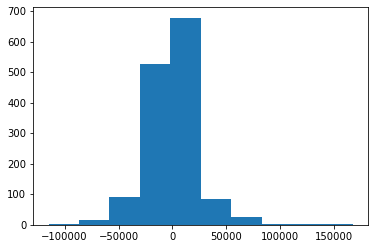

In [74]:
plt.hist(resids);

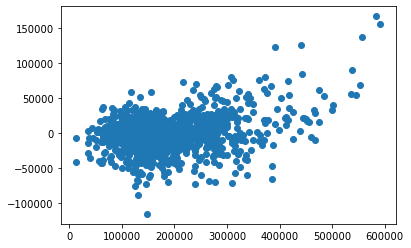

In [75]:
plt.scatter(y_train, resids);

Although not perfectly normal, the distribution of residual values do resemble a normal distribution. The scatterplot of y-values vs residuals does show a little bit of clustering, but it has a generally good shape for residual values. Together this means that the inferences above are fairly trustworthy.

---
## Take Two

When we selected the features for our first linear model, one of our primary goals was to keep the VIF score low. During that process, we ruled out several features that seemed somewhat helpful for predicting the `saleprice` because they pushed the VIF scores a little too high. Let us take a look at some of these features that did not dramatically increase VIF scores, namely:

- `garage_area`
- `wood_deck_sf`
- `open_porch_sf`
- `fireplace_weighted_sf`

The last three features do not seem the most helpful, so we may be modeling a bit more moise with their inclusion. Let us continue and see the results anyways.

In [42]:
# the VIF scores are not extraordinarily high
vif_df(house[['sq_ft', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'fireplaces_weighted']])

,vif
sq_ft,8.865599
garage_area,7.384474
fireplaces_weighted,2.273468
wood_deck_sf,1.737158
open_porch_sf,1.691571


In [43]:
numeric_features = ['sq_ft', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'fireplaces_weighted']
categoric_features = ['neighborhood', 'house_style']
features = numeric_features + categoric_features

In [44]:
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [46]:
lr = LinearRegression()

lr.fit(X_train, y_train)
yt_pred = lr.predict(X_train)
yv_pred = lr.predict(X_val)

In [47]:
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.7995849695216942

Train R squared: 0.8182537391891903
Train RMSE: 34044.136281894214

Validation R squared: 0.8000526626067064
Validation RMSE: 33906.77939815086


We can see that the model score slightly decreases here, even with the additional features. This suggests the new features likely did not contribute much to the models ability to predict `saleprice`. This is unsurprising as it is hard to imagine paying much more money based on wood deck area, open porch area, or number of fireplaces. Let us remove these features in our next iteration and consider other choices.

---

## Take Three

Above we saw very little influence from including several features (wood deck area, open porch area, or number of fireplaces) with low VIF scores. Unfortunately, these features also had low correlation to `saleprice`

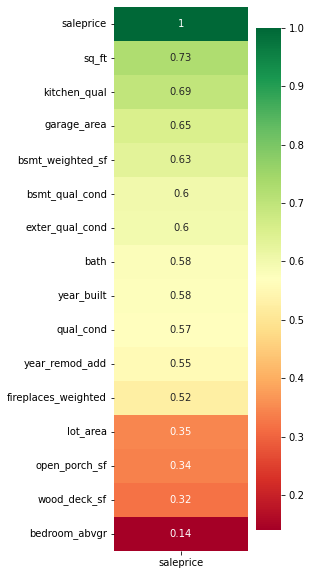

In [84]:
plt.figure(figsize = (3, 10))
corr = house.corr()[['saleprice']].sort_values(by = 'saleprice', ascending = False)
sns.heatmap(corr, cmap = 'RdYlGn', annot = True);

Let us 

- garage area seems like it may have value
- correlations heatmap with saleprice
- VIF scores - not sure what would be best, but consider
- include kitchen quality (as categoric)
- mention in last paragraph the low correlation between 3 features and saleprice (wood, open, fireplaces)

In [48]:
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual']
features = numeric_features + categ_features

In [49]:
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [50]:
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [51]:
lr = LinearRegression()

lr.fit(X_train, y_train)
yt_pred = lr.predict(X_train)
yv_pred = lr.predict(X_val)

In [52]:
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.8534570872514353

Train R squared: 0.8676098959792825
Train RMSE: 29056.10122131043

Validation R squared: 0.8564313103254987
Validation RMSE: 28731.519610336578


---

## Take Four

- We see a significant improvement with the inclusion of bsmt sf and kitchen qual
- we intend to generate a ridge and lasso fit 
- knowing we will fit ridge and lasso, let us include a few more features that seem like they have the most potential for prediction

In [53]:
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf', 'year_built']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual', 'qual_cond', 'exter_qual_cond']
features = numeric_features + categ_features

In [54]:
train_dummy, test_dummy = dummify_train_test(house[features], numeric_features, categ_features)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(train_dummy, y, test_size = 0.3, random_state = 6)

In [56]:
lr = LinearRegression()

lr.fit(X_train, y_train)
yt_pred = lr.predict(X_train)
yv_pred = lr.predict(X_val)

In [57]:
print(f'Train Cross Validation: {cross_val_score(lr, X_train, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {lr.score(X_train, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

print(f'Validation R squared: {lr.score(X_val, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.8904960587650373

Train R squared: 0.914574607035238
Train RMSE: 23340.119254589645

Validation R squared: 0.887738294880876
Validation RMSE: 25406.482714142392


---

## Ridge

In [58]:
alphas = np.logspace(-5, 5, 200)

ridge_cv = RidgeCV(alphas = alphas, cv = 5)

In [59]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [60]:
ridge_cv.fit(X_train_sc, y_train);

In [61]:
ridge_cv.alpha_

42.97004704320844

In [62]:
yt_pred = ridge_cv.predict(X_train_sc)
yv_pred = ridge_cv.predict(X_val_sc)

In [66]:
print(f'Train Cross Validation: {cross_val_score(Ridge(alpha = ridge_cv.alpha_), X_train_sc, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {ridge_cv.score(X_train_sc, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

print(f'Validation R squared: {ridge_cv.score(X_val_sc, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.8920015793096547

Train R squared: 0.9140774915495748
Train RMSE: 23407.932250947517

Validation R squared: 0.8893470167997781
Validation RMSE: 25223.787069644084


---

## Lasso

In [67]:
alphas = np.logspace(-3, 5, 200)

lasso_cv = LassoCV(alphas = alphas, cv = 5)

In [68]:
#X_train_sc is already scaled correctly
lasso_cv.fit(X_train_sc, y_train);

In [69]:
lasso_cv.alpha_

184.64249428955426

In [70]:
yt_pred = lasso_cv.predict(X_train_sc)
yv_pred = lasso_cv.predict(X_val_sc)

In [71]:
print(f'Train Cross Validation: {cross_val_score(Lasso(alpha = lasso_cv.alpha_), X_train_sc, y_train, cv = 5).mean()}\n')
print(f'Train R squared: {ridge_cv.score(X_train_sc, y_train)}')
print(f'Train RMSE: {metrics.mean_squared_error(y_train, yt_pred, squared = False)}\n')

print(f'Validation R squared: {ridge_cv.score(X_val_sc, y_val)}')
print(f'Validation RMSE: {metrics.mean_squared_error(y_val, yv_pred, squared = False)}')

Train Cross Validation: 0.89249108036683

Train R squared: 0.9140774915495748
Train RMSE: 23410.923805793936

Validation R squared: 0.8893470167997781
Validation RMSE: 25173.995930789133


In [249]:
#best model so far, let's try another kaggle submission
#test_dummy was made in model 4's dummify function
X_test_sc = ss.transform(test_dummy)
kag_pred = lasso_cv.predict(X_test_sc)

In [253]:
submit(kag_pred, 8)

In [254]:
# kaggle submission scored 29,051

---

## Train-Test-Split and Building the Linear Regression

In [154]:
X = train_with_dummies
y = house['saleprice']

In [155]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 6)

In [156]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [157]:
lr = LinearRegression()

In [158]:
lr.fit(X_train_sc, y_train)

LinearRegression()

In [159]:
lr.score(X_train_sc, y_train)

0.8251691128036235

In [160]:
lr.score(X_val_sc, y_val)

0.8128736774712252

In [161]:
y_pred = lr.predict(X_val_sc)
metrics.mean_squared_error(y_val, y_pred)

1075950617.0926676

In [162]:
metrics.mean_squared_error(y_val, y_pred, squared = False)

32801.68619282654

In [163]:
#cross val score
cross_val_score(lr, X_train_sc, y_train).mean()

-2.171159208376724e+23

In [164]:
# test_with_dummies was test data modified so model could be applied
# renaming for readability
X_test = test_with_dummies
X_test_sc = ss.transform(X_test)

In [165]:
kag_preds = lr.predict(X_test_sc)

After running the model on the test data and submitting it to Kaggle, the RMSE came out to be 35,257.3 which is significantly higher than RMSE we obtained from our validation set. This suggests that the model is overfit/has high variance.

---

## Take Two (Really Three...) - More Features

Although it is not illustrated above, the linear model I created was my second attempt. In my first attempt, I used the features `sq_ft`, `lot_area`, `neighborhood`, and `house_style` because `lot_area` had a low VIF score when paired with `sq_ft`. I ran into an issue where roughly 1/3 of the time my R squared scores were abyssmal, leading me to believe I had some outliers in the dataset still. I went back and removed some outliers which led to `lot_area` having larger VIF score this time and in the iteration above I included `bsmt_weighted_sf` instead of `lot_area`. This gave me an improvement from an initial RMSE score of 38,000.

Earlier we made a few decisions with a goal of keeping VIF scores low. Let us build another model where we are a bit more lax with this constraint.

In [166]:
vif_df(house[['sq_ft', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'fireplaces_weighted']])

,vif
sq_ft,8.865599
garage_area,7.384474
fireplaces_weighted,2.273468
wood_deck_sf,1.737158
open_porch_sf,1.691571


The VIFs are not great and I do not feel strongly that fireplaces, open porches, and wood decks significantly influence the sales price. I expect the model I build with these variables to be overfit. This will just serve as an experiment to learn from.

In [167]:
numeric_features = ['sq_ft', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'fireplaces_weighted']

I will use the same categoric features as before.

In [168]:
categoric_features = ['neighborhood', 'house_style']

In [169]:
house_test = setup_test()

In [170]:
house

,ms_zoning,lot_area,land_contour,land_slope,neighborhood,condition_1,bldg_type,house_style,year_built,year_remod_add,...,bedroom_abvgr,sale_type,saleprice,qual_cond,exter_qual_cond,bsmt_qual_cond,fireplaces_weighted,sq_ft,bsmt_weighted_sf,bath
0,RL,13517,Lvl,Gtl,Sawyer,RRAe,1Fam,2Story,1976,2005,...,3,WD,130500,48,12,9,0,1479,629.0,2.5
1,RL,11492,Lvl,Gtl,SawyerW,Norm,1Fam,2Story,1996,1997,...,4,WD,220000,35,12,12,3,2122,775.0,2.5
2,RL,7922,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1953,2007,...,3,WD,109000,35,12,9,0,1057,894.0,1.0
3,RL,9802,Lvl,Gtl,Timber,Norm,1Fam,2Story,2006,2007,...,3,WD,174000,25,9,12,0,1444,192.0,2.5
4,RL,14235,Lvl,Gtl,SawyerW,Norm,1Fam,1.5Fin,1900,1993,...,3,WD,138500,48,9,8,0,1445,338.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,RL,11449,HLS,Gtl,Timber,Norm,1Fam,1Story,2007,2007,...,3,WD,298751,40,12,12,4,1728,1447.5,2.0
2047,RL,12342,Lvl,Gtl,Edwards,Norm,1Fam,1Story,1940,1950,...,1,WD,82500,20,9,9,0,861,561.5,1.0
2048,RL,7558,Bnk,Gtl,Crawfor,Norm,1Fam,1.5Fin,1928,1950,...,3,WD,177000,36,9,9,3,1913,448.0,1.5
2049,RL,10400,Lvl,Gtl,NAmes,Norm,1Fam,1Story,1956,1956,...,3,WD,144000,20,9,9,8,1200,302.5,1.0


In [171]:
dummy_train, dummy_test = dummify_train_test(house, numeric_features, categoric_features)

In [188]:
X_train, X_val, y_train, y_val = train_test_split(dummy_train, house['saleprice'], test_size = 0.3, random_state = 3)

In [189]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [190]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_train_sc)
y_val_pred = lr.predict(X_val_sc)

In [191]:
print(lr.score(X_train_sc, y_train))
print(lr.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, y_pred))
print(metrics.mean_squared_error(y_train, y_pred, squared = False))
print(metrics.mean_squared_error(y_val, y_val_pred))
print(metrics.mean_squared_error(y_val, y_val_pred, squared = False))

0.8226814012023593
-1.9145771122778445e+21
1134915862.8814733
33688.51232811377
1.0899471245546081e+31
3301434725319596.5


In [192]:
cross_val_score(lr, X_train_sc, y_train).mean()

0.8051412777713736

We see above that the Root Mean Squared Errors do not appear to be better than our previous model despite including more features. Unfortunately, our validation score did not make clear that our previous model was overfit. This model could very well be overfit, too. Or this model could be better and the agreement between the train and validation scores could be more authentic now that we have included more features.

One thing to note is that we would expect our R squared scores to improve from adding features. Since our R squared score did not increase, it could mean two things:
1. The previous R squared score was inflated and the new features are producing a more authentically higher R squared score,
2. or the new features contribute negligible guidance for predicting the sale price of homes. This is probably more likely.

Regardless, we should still search for a more convincingly successful model.

---

## Take Three - Kitchen Quality

In our first approach, we converted the kitchen quality ratings from descriptive ratings to numeric ratings. This could be problematic because a numbered rating system introduces an implicit relationships between the ratings that did not exist before. For example, a house may have a kitchen quality of 4 while another has a kitchen quality of 2. This does not necessarily mean the first home's kitchen is twice as nice as the second.

Let us plan to one-hot-encode `kitchen_qual`. As for numeric columns, we will use `sq_ft` again with `bsmt_weighted_sf` as these seem to be the most relevant columns that still produce low VIFs.

In [173]:
#
# Edit above: include plan to overfit a bit
# test the model
#
# include ridge
#

In [124]:
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual']

In [125]:
dummy_train, dummy_test = dummify_train_test(house, numeric_features, categ_features)

In [126]:
y = house['saleprice']

In [127]:
X_train, X_val, y_train, y_val = train_test_split(dummy_train, y, test_size = 0.3, random_state = 6)

In [128]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [129]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
yt_pred = lr.predict(X_train_sc)
yv_pred = lr.predict(X_val_sc)

In [130]:
print(lr.score(X_train_sc, y_train))
print(lr.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.8759465544939518
0.8666992405886502
703035284.6262172
26514.812551217805
718335624.0543063
26801.783971487912


In [131]:
cross_val_score(lr, X_train_sc, y_train).mean()

0.8626531975648142

It is not clear to me why these warnings appear, but they do not seem to harm the code's ability to produce metrics on our regression. The R squared scores of our model are extremely poor but the RMSE scores are a bit better. 

In [234]:
#
# Edit above line, fixed:
# issue was running scores on unscaled datasets when fit was scaled
#
# 

In [235]:
# Now I am curious what will happen to my model's performance if I am a little more lax on my choice of features. Earlier we made decisions to leave out some features because they contributed to large VIFs (`garage_area`) or they seemed like they only applied to a significantly smaller subset of the data (``)

---

## Ridge

In [132]:
alphas = np.logspace(0, 5, 100)

ridge_cv = RidgeCV(alphas = alphas, cv = 5)

In [133]:
# using the same train test split as above
# X_train and X_val have already been 'standard scaled'
# expressed as X_train_sc and X_val_sc

ridge_cv.fit(X_train_sc, y_train);

In [134]:
ridge_cv.alpha_

1.0

In [135]:
alphas = np.logspace(-10, 1, 100)

ridge_cv = RidgeCV(alphas = alphas, cv = 5)

In [136]:
# using the same train test split as above
# X_train and X_val have already been 'standard scaled'
# expressed as X_train_sc and X_val_sc

ridge_cv.fit(X_train_sc, y_train);

In [137]:
ridge_cv.alpha_

1e-10

In both instances of running `RidgeCV`, the optimal alpha value is the lowest. This means that Ridge views our model as a good fit already and believes the penalty term is not very necessary. For the sake of example, let us fit a Ridge regression with the default alpha = 1 that our first RidgeCV suggested.

In [138]:
ridge = Ridge()

In [140]:
ridge.fit(X_train_sc, y_train);

In [142]:
yt_pred = ridge.predict(X_train_sc)
yv_pred = ridge.predict(X_val_sc)

In [143]:
print(ridge.score(X_train_sc, y_train))
print(ridge.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.8759446677927176
0.8667628148927261
703045976.9333413
26515.01417939167
717993032.7022852
26795.39200501245


In [141]:
cross_val_score(ridge, X_train_sc, y_train).mean()

0.8631841956284261

---

## Take Four - Lot Area and Quality/Condition

We will eventually use Ridge and Lasso to deal with overfit models. First, let us include a few more variables that may make our model overfit. Namely, let us include `lot_area` and `qual_cond`.

In [285]:
numeric_features = ['sq_ft', 'garage_area', 'bsmt_weighted_sf', 'lot_area', 'qual_cond']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual']

In [286]:
dummy_train, dummy_test = dummify_train_test(house, numeric_features, categ_features)

In [287]:
X_train, X_val, y_train, y_val = train_test_split(dummy_train, y, test_size = 0.3, random_state = 8)

In [288]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [289]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
yt_pred = lr.predict(X_train_sc)
yv_pred = lr.predict(X_val_sc)

In [290]:
print(lr.score(X_train_sc, y_train))
print(lr.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.8947403220017641
0.9018904981266351
585153630.4006903
24189.94895407368
553068947.5777028
23517.417961538693


In [291]:
X_test_sc = ss.transform(dummy_test)

In [292]:
kag_preds = lr.predict(X_test_sc)

Our scores once again improve, though not very significantly. Feeling more confident that our model is overfit, let us now use Ridge and Lasso.

In [293]:
submit(raw_house_test, kag_preds, 5)

The Kaggle submission score was 30,007, which again is significantly lower than the scores anticipate.

--- 

## Take Five - Even More Features

In [294]:
house.select_dtypes('number').columns

Index(['lot_area', 'year_built', 'year_remod_add', 'garage_area',
       'wood_deck_sf', 'open_porch_sf', 'kitchen_qual', 'bedroom_abvgr',
       'saleprice', 'bsmt_qual_cond', 'fireplaces_weighted',
       'bsmt_weighted_sf', 'qual_cond', 'exter_qual_cond', 'bath', 'sq_ft'],
      dtype='object')

In [295]:
house.select_dtypes('object').columns

Index(['ms_zoning', 'land_contour', 'land_slope', 'neighborhood',
       'condition_1', 'bldg_type', 'house_style', 'mas_vnr_type', 'sale_type'],
      dtype='object')

In [296]:
numeric_features = ['sq_ft', 'bedroom_abvgr', 'garage_area', 'bsmt_weighted_sf', 'lot_area', 'year_built', 'bath', 'qual_cond', 'fireplaces_weighted']
categ_features = ['neighborhood', 'house_style', 'kitchen_qual']

In [297]:
dummy_train, dummy_test = dummify_train_test(house, numeric_features, categ_features)

In [298]:
X_train, X_val, y_train, y_val = train_test_split(dummy_train, y, test_size = 0.2, random_state = 8)

In [299]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [300]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
yt_pred = lr.predict(X_train_sc)
yv_pred = lr.predict(X_val_sc)

In [301]:
print(lr.score(X_train_sc, y_train))
print(lr.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.9075228715252514
0.9100119238912097
509583060.948662
22573.946508057958
528836763.0327791
22996.451096479628


In [302]:
X_test_sc = ss.transform(dummy_test)

In [303]:
kag_preds = lr.predict(X_test_sc)

In [304]:
submit(raw_house_test, kag_preds, 6)

---

## Lasso

In [305]:
alphas = np.logspace(0, 5, 100)

lasso_cv = LassoCV(alphas = alphas, cv = 5)

In [306]:
lasso_cv.fit(X_train_sc, y_train);

In [307]:
lasso_cv.alpha_

298.364724028334

In [314]:
alphas = np.logspace(-10, 1, 100)

lasso_cv =LassoCV(alphas = alphas, cv = 5)

In [315]:
lasso_cv.fit(X_train_sc, y_train);

In [316]:
lasso_cv.alpha_

10.0

We see above that our Lasso model was best fit with alpha = 298.

In [317]:
lasso = Lasso(alpha = 298.36)

In [318]:
lasso.fit(X_train_sc, y_train);

In [322]:
yt_pred = lasso.predict(X_train_sc)
yv_pred = lasso.predict(X_val_sc)

In [323]:
print(lasso.score(X_train_sc, y_train))
print(lasso.score(X_val_sc, y_val))
print(metrics.mean_squared_error(y_train, yt_pred))
print(metrics.mean_squared_error(y_train, yt_pred, squared = False))
print(metrics.mean_squared_error(y_val, yv_pred))
print(metrics.mean_squared_error(y_val, yv_pred, squared = False))

0.9067927186731571
0.9105503346489553
513606472.2663283
22662.887553582583
525672661.5804485
22927.552455080076


In [324]:
lasso_kag_preds = lasso.predict(X_test_sc)

In [325]:
submit(raw_house_test, lasso_kag_preds, 7)

Kaggle score: 27,992.